In [24]:
#Model A - Baseline Model CNN

In [34]:

import os, random, numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [35]:
DATASET_DIRECTORY = r"/content/sample_data/natural_images"
SPLIT_FILE = "splits.npz"

IMAGE_SIZE = 160
BATCH_SIZE = 32
EPOCHS = 12
LEARNING_RATE = 1e-3

NUM_WORKERS = 0
PIN_MEMORY = False


MAX_TRAIN_BATCHES = None

In [36]:
#Transformations
eval_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [37]:
# Create dataset and splits
base_dataset = datasets.ImageFolder(DATASET_DIRECTORY, transform=eval_tfms)
n = len(base_dataset)

train_size = int(0.70 * n)
validation_size   = int(0.15 * n)
test_size  = n - train_size - validation_size

g = torch.Generator().manual_seed(42)
train_split, validation_split, test_split = torch.utils.data.random_split(
    range(n), [train_size, validation_size, test_size], generator=g
)

train_index = np.array(train_split.indices)
validation_index   = np.array(validation_split.indices)
test_index  = np.array(test_split.indices)

np.savez(SPLIT_FILE, train_idx=train_index, validation_index=validation_index, test_index=test_index)

print("Saved:", SPLIT_FILE)
print("Sizes:", len(train_index), len(validation_index), len(test_index))
print("Classes:", base_dataset.classes)

Saved: splits.npz
Sizes: 4829 1034 1036
Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [38]:
#Subsets and DataLoaders
def subset_with_transform(data_directory, indices, transform):
    dataset = datasets.ImageFolder(data_directory, transform=transform)
    dataset.samples = [dataset.samples[i] for i in indices]
    dataset.targets = [dataset.targets[i] for i in indices]
    return dataset

train_tfms_A = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_dataset = subset_with_transform(DATASET_DIRECTORY, train_index, train_tfms_A)
validation_dataset   = subset_with_transform(DATASET_DIRECTORY, validation_index, eval_tfms)
test_dataset  = subset_with_transform(DATASET_DIRECTORY, test_index, eval_tfms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
validation_loader   = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

class_names = base_dataset.classes
num_classes = len(class_names)
print("num_classes:", num_classes)

num_classes: 8


In [39]:
#Baseline CNN Model with Global Average Pooling for Efficiency
class BaselineCNN_GAP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        return self.classifier(x)

model = BaselineCNN_GAP(num_classes).to(device)


Epoch 01 | train loss:1.4664 / train acc:0.4713 | validation loss:1.1982 / validation acc0.6054
Epoch 02 | train loss:0.9722 / train acc:0.6683 | validation loss:0.8709 / validation acc0.7137
Epoch 03 | train loss:0.7926 / train acc:0.7285 | validation loss:0.7677 / validation acc0.7505
Epoch 04 | train loss:0.6856 / train acc:0.7668 | validation loss:0.6306 / validation acc0.7988
Epoch 05 | train loss:0.6187 / train acc:0.7855 | validation loss:0.6052 / validation acc0.8037
Epoch 06 | train loss:0.5704 / train acc:0.7979 | validation loss:0.5399 / validation acc0.8269
Epoch 07 | train loss:0.4978 / train acc:0.8277 | validation loss:0.4636 / validation acc0.8453
Epoch 08 | train loss:0.4791 / train acc:0.8335 | validation loss:0.4436 / validation acc0.8375
Epoch 09 | train loss:0.4200 / train acc:0.8492 | validation loss:0.4072 / validation acc0.8694
Epoch 10 | train loss:0.4177 / train acc:0.8459 | validation loss:0.4389 / validation acc0.8453
Epoch 11 | train loss:0.3798 / train acc

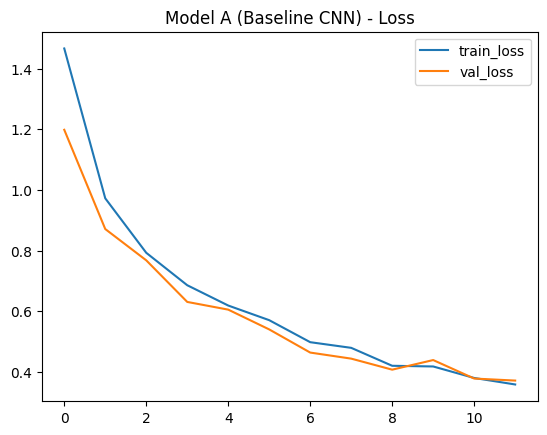

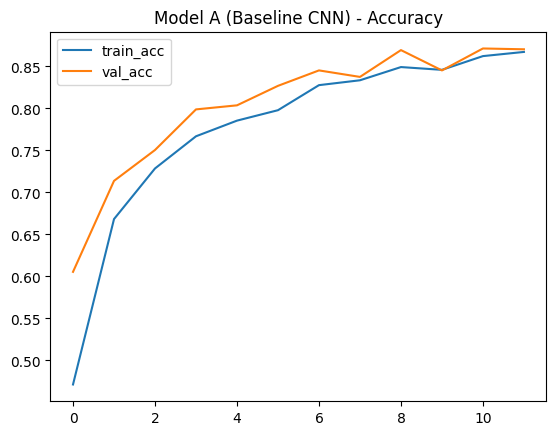

In [40]:
#Training and Evaluation Functions
def run_epoch(model, loader, optimizer=None, max_batches=None):
    is_train = optimizer is not None
    model.train(is_train)
    loss_fn = nn.CrossEntropyLoss()

    total_loss, total_correct, total_n = 0.0, 0, 0

    for i, (x, y) in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break

        x, y = x.to(device), y.to(device)

        if is_train:
            optimizer.zero_grad()

        logits = model(x)
        loss = loss_fn(logits, y)

        if is_train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_n += x.size(0)

    return total_loss / total_n, total_correct / total_n

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    ys, preds = [], []
    for x, y in loader:
        logits = model(x.to(device))
        p = logits.argmax(1).cpu().numpy()
        preds.extend(p)
        ys.extend(y.numpy())
    return np.array(ys), np.array(preds)

def plot_history(hist, title):
    plt.figure()
    plt.plot(hist["train_loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.legend()
    plt.title(title + " - Loss")
    plt.show()

    plt.figure()
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["val_acc"], label="val_acc")
    plt.legend()
    plt.title(title + " - Accuracy")
    plt.show()

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_val = -1
best_state = None

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(model, train_loader, optimizer=optimizer, max_batches=MAX_TRAIN_BATCHES)
    va_loss, va_acc = run_epoch(model, validation_loader, optimizer=None)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    if va_acc > best_val:
        best_val = va_acc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    print(f"Epoch {ep:02d} | train loss: {tr_loss:.4f} / train acc: {tr_acc:.4f} | validation loss: {va_loss:.4f} / validation acc: {va_acc:.4f}")

model.load_state_dict(best_state)
plot_history(history, "Model A (Baseline CNN)")

Model A Test Accuracy: 0.1506
Confusion Matrix:
 [[  0   0  95   5   0   0   0   0]
 [  0   0 149   2   0   0   0   0]
 [  0   0 139  17   0   0   0   0]
 [  0   0  90  17   0   0   0   0]
 [  0   0 121  16   0   1   0   0]
 [  0   0  48  85   0   0   0   0]
 [  0   0 112  12   0   0   0   0]
 [  0   0 115  12   0   0   0   0]]

Classification Report:

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00       100
         car       0.00      0.00      0.00       151
         cat       0.16      0.89      0.27       156
         dog       0.10      0.16      0.12       107
      flower       0.00      0.00      0.00       138
       fruit       0.00      0.00      0.00       133
   motorbike       0.00      0.00      0.00       124
      person       0.00      0.00      0.00       127

    accuracy                           0.15      1036
   macro avg       0.03      0.13      0.05      1036
weighted avg       0.03      0.15      0.05      

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


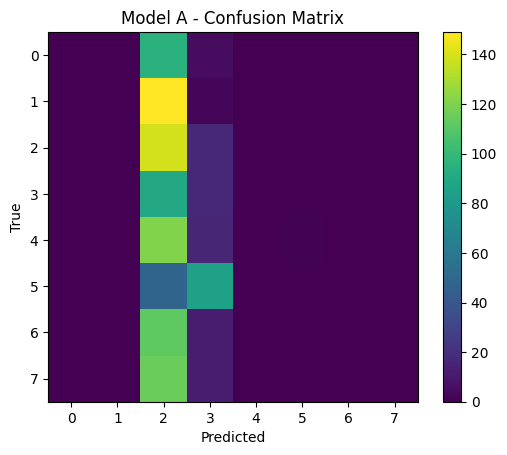

In [ ]:
#Test Evaluation and Metrics
y_true, y_pred = predict_all(model, test_loader)
test_acc = (y_true == y_pred).mean()
print("Model A Test Accuracy:", round(float(test_acc), 4))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure()
plt.imshow(cm)
plt.title("Model A - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()